In [1]:
from pathlib import Path

import folium
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
from shapely.geometry import Point
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score

In [2]:
skipped_regions = pd.read_csv("/Volumes/x10pro/estuary/geos/skipped_regions.csv")[
    "Site code"
].to_list()

In [58]:
gdf = gpd.read_file("/Users/kyledorman/data/estuary/geos/ca_data_w_usgs.geojson")
gdf = gdf[~gdf["Site code"].isin(skipped_regions)].copy()
gdf = gdf.set_index("Site code")
gdf.head()

,Latitude,Longitude,Region,Nation,Site name,Studied (1) / Not Studied (0),station_nm,site_no,site_latitude,site_longitude,geometry
Site code,,,,,,,,,,,
11,32.933,-117.260,North America,USA,Los Penasquitos Lagoon,1,None,None,None,None,POINT (-117.26 32.933)
12,33.166,-117.358,North America,USA,Buena Vista Lagoon,0,None,None,None,None,POINT (-117.358 33.166)
14,33.203,-117.391,North America,USA,San Luis Rey River,0,None,None,None,None,POINT (-117.391 33.203)
15,33.231,-117.416,North America,USA,Santa Margarita River,1,SANTA MARGARITA RIVER ESTUARY NR OCEANSIDE CA,11046050,33.2294795,-117.4103174,POINT (-117.416 33.231)
16,33.291,-117.465,North America,USA,Las Fores Creek,0,LAS FLORES C LAGOON A MOUTH NR OCEANSIDE CA,11046102,33.29055556,-117.465,POINT (-117.465 33.291)


In [4]:
rect_df = []

for pth in Path("/Volumes/x10pro/estuary/ca_grids/").iterdir():
    gid = int(pth.stem)
    if gid in skipped_regions:
        continue
    tp_df = gpd.read_file(pth)
    geo = tp_df.iloc[0].geometry
    rect_df.append({"Site code": gid, "geometry": geo, "Site name": gdf.loc[gid]["Site name"]})

rect_df = gpd.GeoDataFrame(rect_df, geometry="geometry", crs=tp_df.crs)
rect_df.head()

,Site code,geometry,Site name
0,16,"POLYGON ((-117.45996 33.28668, -117.46 33.2940...",Las Fores Creek
1,64,"POLYGON ((-122.39691 37.35474, -122.39686 37.3...",Tunitas Creek
2,39,"POLYGON ((-121.12303 35.59242, -121.12287 35.5...",Van Gordon Creek
3,29,"POLYGON ((-119.65962 34.41434, -119.65979 34.4...",None
4,52,"POLYGON ((-122.07403 36.95069, -122.07396 36.9...",None


In [5]:
mm = []
for site_code, row in gdf.iterrows():
    matches = rect_df[rect_df.intersects(row.geometry)]
    if len(matches) and (matches["Site code"] == site_code).all():
        mm.append(site_code)
gdf.loc[(rect_df[~rect_df["Site code"].isin(mm)]["Site code"])]

,Latitude,Longitude,Region,Nation,Site name,Studied (1) / Not Studied (0),station_nm,site_no,site_latitude,site_longitude,geometry
Site code,,,,,,,,,,,
2163,32.555798,-117.127163,North America,USA,Tijuana River Estuary,1,None,None,None,None,POINT (-117.12716 32.5558)
58,36.979000,-122.143000,North America,USA,Majors Creek,0,None,None,None,None,POINT (-122.143 36.979)
94,41.171000,-124.128000,North America,USA,Big Lagoon,0,None,None,None,None,POINT (-124.128 41.171)
61,37.037000,-122.228000,North America,USA,Molino Creek,0,None,None,None,None,POINT (-122.228 37.037)


In [6]:
df = pd.read_csv("/Users/kyledorman/Downloads/EMPA_Field_Grab.csv")
df = df[df.latitude > -87]
df.loc[df.longitude > 0, "longitude"] = df[df.longitude > 0].longitude * -1
df = df[df.tide != "Not recorded"]

# Step 1: parse as datetime (no tz yet)
df["samplecollectiondate"] = pd.to_datetime(df["samplecollectiondate"], errors="coerce")

# Step 2: localize to Pacific at midnight
df["samplecollectiondate"] = (
    df["samplecollectiondate"]
    .dt.tz_localize("America/Los_Angeles")
    # Step 3: shift to noon
    .dt.floor("D")
    + pd.Timedelta(hours=12)
)

# Step 4: convert to UTC for storage
df["samplecollectiondate"] = df["samplecollectiondate"].dt.tz_convert("UTC")
df.head()

,objectid,projectid,agency,siteid,estuaryname,stationno,samplecollectiondate,grabno,tide,latitude,...,pfas,pfasfieldblank,equipmentblank,datacollector,dataentryperson,comments,region,estuaryclass,mpastatus,estuarytype
0,1063,Baja-rails,SCCWRP,Baja-PB,Estero Punta Banda,1,2022-04-26 19:00:00+00:00,1,ebb,31.751050,...,No,No,No,JW,JW,NaN,Baja,Embayment,NON-MPA,Perennially Open
1,923,Baja-rails,SCCWRP,Baja-PB,Estero Punta Banda,1,2022-04-27 19:00:00+00:00,1,low,31.754150,...,No,No,No,JW,JW,NaN,Baja,Embayment,NON-MPA,Perennially Open
2,922,Baja-rails,SCCWRP,Baja-PB,Estero Punta Banda,1,2022-04-27 19:00:00+00:00,2,low,31.754120,...,No,No,No,JW,JW,NaN,Baja,Embayment,NON-MPA,Perennially Open
3,924,Baja-rails,SCCWRP,Baja-PB,Estero Punta Banda,1,2022-04-27 19:00:00+00:00,3,low,31.754250,...,No,No,No,JW,JW,NaN,Baja,Embayment,NON-MPA,Perennially Open
4,1070,Baja-rails,SCCWRP,Baja-PB,Estero Punta Banda,1,2022-10-12 19:00:00+00:00,1,low,31.753911,...,No,No,No,Osmar,JW,NaN,Baja,Embayment,NON-MPA,Perennially Open


In [7]:
rpoints = {}
for r, rows in df.groupby(["siteid", "stationno"]):
    lon = rows.longitude.median()
    lat = rows.latitude.median()
    rpoints[r] = Point(lon, lat)

len(rpoints)

122

In [8]:
# Convert lat/lon to shapely Points
geometry = [rpoints[(r.siteid, r.stationno)] for _, r in df.iterrows()]

# Create a GeoDataFrame
empa_gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")

empa_gdf.head()

,objectid,projectid,agency,siteid,estuaryname,stationno,samplecollectiondate,grabno,tide,latitude,...,pfasfieldblank,equipmentblank,datacollector,dataentryperson,comments,region,estuaryclass,mpastatus,estuarytype,geometry
0,1063,Baja-rails,SCCWRP,Baja-PB,Estero Punta Banda,1,2022-04-26 19:00:00+00:00,1,ebb,31.751050,...,No,No,JW,JW,NaN,Baja,Embayment,NON-MPA,Perennially Open,POINT (-116.61833 31.75394)
1,923,Baja-rails,SCCWRP,Baja-PB,Estero Punta Banda,1,2022-04-27 19:00:00+00:00,1,low,31.754150,...,No,No,JW,JW,NaN,Baja,Embayment,NON-MPA,Perennially Open,POINT (-116.61833 31.75394)
2,922,Baja-rails,SCCWRP,Baja-PB,Estero Punta Banda,1,2022-04-27 19:00:00+00:00,2,low,31.754120,...,No,No,JW,JW,NaN,Baja,Embayment,NON-MPA,Perennially Open,POINT (-116.61833 31.75394)
3,924,Baja-rails,SCCWRP,Baja-PB,Estero Punta Banda,1,2022-04-27 19:00:00+00:00,3,low,31.754250,...,No,No,JW,JW,NaN,Baja,Embayment,NON-MPA,Perennially Open,POINT (-116.61833 31.75394)
4,1070,Baja-rails,SCCWRP,Baja-PB,Estero Punta Banda,1,2022-10-12 19:00:00+00:00,1,low,31.753911,...,No,No,Osmar,JW,NaN,Baja,Embayment,NON-MPA,Perennially Open,POINT (-116.61833 31.75394)


In [9]:
all_sensors = gpd.GeoDataFrame(
    [{"siteid": s, "stationno": ss, "geometry": p} for (s, ss), p in rpoints.items()], crs="wgs84"
)

nearests = (
    gpd.sjoin_nearest(
        all_sensors.to_crs("ESRI:54008"),
        gdf[["geometry", "Site name"]].to_crs("ESRI:54008"),
        how="inner",
        max_distance=1700,
        distance_col="dist",
    )
    .sort_values(by=["Site code", "dist", "siteid"])
    .drop_duplicates(["siteid", "Site code"])
)

# Manualally reviewed and filtered
nearests = nearests[nearests.siteid != "SC-CARP"]

nearests

,siteid,stationno,geometry,Site code,Site name,dist
82,SC-LPL,1,POINT (-10966442.258 3645286.986),11,Los Penasquitos Lagoon,159.609513
120,SC-ZUM,1,POINT (-10975369.886 3765301.653),18,Zuma Lagoon,52.679315
117,SC-VEN,1,POINT (-10986576.565 3794263.565),21,Ventura River,109.397918
71,SC-DEV,2,POINT (-11020036.127 3810000.848),25,Deveereux Slough,1694.210477
75,SC-GOL,3,POINT (-11015804.282 3809992.861),28,San Pedro Creek,118.996819
7,CC-ADLC,1,POINT (-10977614.232 3953348.03),43,Arroyo De La Laguna,50.616665
9,CC-CAR,1,POINT (-10918248.751 4045133.883),48,Carmel River,125.976501
24,CC-SALI,1,POINT (-10877965.354 4068102.422),50,Salinas River,730.561120
21,CC-PAJ,1,POINT (-10863233.712 4080085.49),51,Pajaro River,167.108708
46,NC-RUSR,1,POINT (-10748329.874 4257198.924),72,Russian River,445.139228


In [10]:
matching_sites = {}
for _, row in nearests.iterrows():
    if row["Site code"] in matching_sites:
        continue
    matching_sites[row["Site code"]] = row.siteid

revmatching_sites = {v: k for k, v in matching_sites.items()}

# with open("/Users/kyledorman/data/estuary/geos/ca_empa_matching_sites.json", "w") as f:
#     json.dump(matching_sites, f)

matching_sites

{11: 'SC-LPL',
 18: 'SC-ZUM',
 21: 'SC-VEN',
 25: 'SC-DEV',
 28: 'SC-GOL',
 43: 'CC-ADLC',
 48: 'CC-CAR',
 50: 'CC-SALI',
 51: 'CC-PAJ',
 72: 'NC-RUSR',
 84: 'NC-NAV',
 2145: 'SC-MAL',
 2161: 'SC-MUGU',
 2162: 'SC-SDL',
 2163: 'SC-TJES'}

In [11]:
filt_empa_gdf = empa_gdf[empa_gdf.siteid.isin(list(matching_sites.values()))].copy()
filt_empa_gdf.head()

,objectid,projectid,agency,siteid,estuaryname,stationno,samplecollectiondate,grabno,tide,latitude,...,pfasfieldblank,equipmentblank,datacollector,dataentryperson,comments,region,estuaryclass,mpastatus,estuarytype,geometry
110,1097,Bight-Estuary-23,SCCWRP,SC-DEV,Devereaux Slough,1,2023-11-02 19:00:00+00:00,1,closed,34.420010,...,No,No,NaN,NaN,NaN,South,Lagoonal,NON-MPA,Temporarily Closed,POINT (-119.87539 34.42001)
111,1098,Bight-Estuary-23,SCCWRP,SC-DEV,Devereaux Slough,2,2023-11-02 19:00:00+00:00,1,closed,34.417750,...,No,No,NaN,NaN,NaN,South,Lagoonal,NON-MPA,Temporarily Closed,POINT (-119.8741 34.41775)
123,1374,Bight-Estuary-23,TRNERR,SC-LPL,Los Penasquitos Lagoon,1,2023-11-08 20:00:00+00:00,1,low,32.932725,...,No,No,JC,JW,NaN,South,Riverine,NON-MPA,Temporarily Closed,POINT (-117.25796 32.93272)
124,1358,Bight-Estuary-23,TRNERR,SC-LPL,Los Penasquitos Lagoon,1,2023-12-11 20:00:00+00:00,1,low,32.932725,...,No,No,JC,JW,NaN,South,Riverine,NON-MPA,Temporarily Closed,POINT (-117.25796 32.93272)
125,1375,Bight-Estuary-23,TRNERR,SC-LPL,Los Penasquitos Lagoon,2,2023-11-08 20:00:00+00:00,1,low,32.933352,...,No,No,JC,JW,NaN,South,Riverine,NON-MPA,Temporarily Closed,POINT (-117.25442 32.93335)


In [12]:
filt_empa_gdf.tide.unique()

array(['closed', 'low', 'flood', 'high', 'mid', 'ebb', 'open'],
      dtype=object)

In [13]:
for (s, d), rows in filt_empa_gdf.groupby(["estuaryname", "samplecollectiondate"]):
    if not (rows.tide == rows.iloc[0].tide).all():
        print(s, d)
        print(rows.tide.tolist())

Arroyo de la Cruz 2024-10-15 19:00:00+00:00
['high', 'low']
Carmel River 2024-04-10 19:00:00+00:00
['high', 'closed']
Goleta Slough 2021-09-20 19:00:00+00:00
['high', 'closed', 'closed', 'high', 'closed', 'high', 'closed', 'closed', 'closed']
Goleta Slough 2021-09-21 19:00:00+00:00
['closed', 'high', 'closed', 'closed']
Malibu Lagoon 2021-04-06 19:00:00+00:00
['low', 'ebb', 'low', 'ebb', 'ebb']
Pajaro River 2021-10-06 19:00:00+00:00
['high', 'high', 'closed', 'high']
Pajaro River 2023-10-24 19:00:00+00:00
['mid', 'mid', 'mid', 'high', 'high', 'high', 'mid', 'mid', 'mid']
Ventura River 2021-03-29 19:00:00+00:00
['ebb', 'ebb', 'ebb', 'ebb', 'low', 'ebb']
Ventura River 2021-09-22 19:00:00+00:00
['high', 'closed', 'closed', 'high', 'closed', 'high', 'high', 'closed', 'closed', 'closed']


In [14]:
filt_empa_gdf["mouth_closed"] = filt_empa_gdf.tide == "closed"

empa_labels = filt_empa_gdf.groupby(["estuaryname", "samplecollectiondate"], as_index=False).agg(
    {"mouth_closed": "any"}
)
empa_labels["Site code"] = -1
empa_labels["siteid"] = ""
for idx, row in empa_labels.iterrows():
    siteid = filt_empa_gdf[filt_empa_gdf.estuaryname == row.estuaryname].siteid.iloc[0]
    code = revmatching_sites[siteid]
    empa_labels.loc[idx, "Site code"] = code
    empa_labels.loc[idx, "siteid"] = siteid

print(len(empa_labels))

empa_labels.head()

78


,estuaryname,samplecollectiondate,mouth_closed,Site code,siteid
0,Arroyo de la Cruz,2021-10-25 19:00:00+00:00,False,43,CC-ADLC
1,Arroyo de la Cruz,2021-10-28 19:00:00+00:00,True,43,CC-ADLC
2,Arroyo de la Cruz,2023-10-17 19:00:00+00:00,True,43,CC-ADLC
3,Arroyo de la Cruz,2024-04-22 19:00:00+00:00,False,43,CC-ADLC
4,Arroyo de la Cruz,2024-10-15 19:00:00+00:00,False,43,CC-ADLC


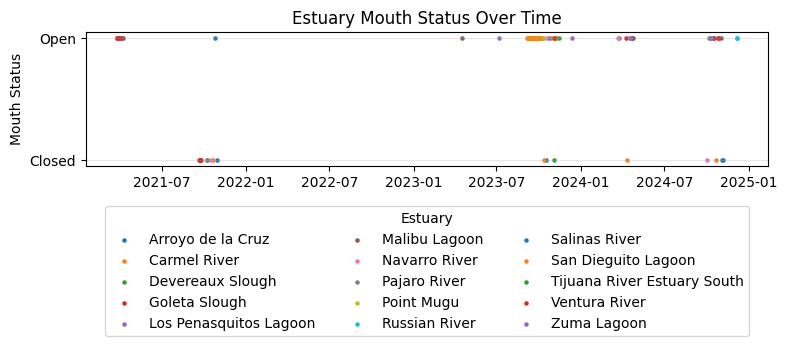

In [15]:
# Convert to numeric: open=1, closed=0
empa_labels["mouth_status"] = (~empa_labels["mouth_closed"]).astype(int)

# One figure
plt.figure(figsize=(8, 4))

# Plot each estuary separately
for estuary, g in empa_labels.groupby("estuaryname"):
    g = g.sort_values("samplecollectiondate")
    plt.scatter(
        g["samplecollectiondate"],
        g["mouth_status"],
        marker="o",
        label=estuary,
        s=5,
    )

plt.yticks([0, 1], ["Closed", "Open"])
plt.ylabel("Mouth Status")
plt.title("Estuary Mouth Status Over Time")
plt.legend(
    title="Estuary",
    loc="upper center",
    bbox_to_anchor=(0.5, -0.25),  # push down below x-axis
    ncol=3,  # spread entries into columns
)
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

In [16]:
empa_labels.groupby("estuaryname", as_index=False).agg(
    total_count=("mouth_closed", "size"), closed_pct=("mouth_closed", "mean")
).round(2)

,estuaryname,total_count,closed_pct
0,Arroyo de la Cruz,5,0.40
1,Carmel River,4,1.00
2,Devereaux Slough,1,1.00
3,Goleta Slough,7,0.29
4,Los Penasquitos Lagoon,2,0.00
5,Malibu Lagoon,7,0.14
6,Navarro River,5,0.40
7,Pajaro River,5,0.20
8,Point Mugu,13,0.00
9,Russian River,2,0.00


In [17]:
lookup = dict(zip(df.siteid, df.estuaryname, strict=False))
revlookup = dict(zip(df.estuaryname, df.siteid, strict=False))

sensors = gpd.GeoDataFrame(
    [
        {"siteid": s, "estuaryname": lookup[s], "stationno": ss, "geometry": p}
        for (s, ss), p in rpoints.items()
        if s in list(matching_sites.values())
    ],
    crs="wgs84",
)
# sensors.to_file("/Users/kyledorman/data/estuary/geos/filtered_empa_sites.geojson")

lookup = dict(zip(df.siteid, df.estuaryname, strict=False))

sensors = gpd.GeoDataFrame(
    [
        {"siteid": s, "estuaryname": lookup[s], "stationno": ss, "geometry": p}
        for (s, ss), p in rpoints.items()
    ],
    crs="wgs84",
)
# sensors.to_file("/Users/kyledorman/data/estuary/geos/empa_sites.geojson")

In [18]:
sensors = gpd.GeoDataFrame(
    [
        {"siteid": s, "estuaryname": lookup[s], "stationno": ss, "geometry": p}
        for (s, ss), p in rpoints.items()
        if s not in list(matching_sites.values())
    ],
    crs="wgs84",
)

aaa = gpd.read_file("/Users/kyledorman/data/estuary/geos/ca_data.geojson")
aaa = aaa[~aaa["Site code"].isin(list(matching_sites.keys()))]

# Initialize map centered on all data
bounds = aaa.total_bounds  # [minx, miny, maxx, maxy]
m = folium.Map(location=[(bounds[1] + bounds[3]) / 2, (bounds[0] + bounds[2]) / 2], zoom_start=8)

# Add sites (one color)
for _, row in aaa.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=6,
        color="black",
        fill=True,
        fill_color="black",
        popup=f"Site: {row['Site code']}",
    ).add_to(m)

# Add sensor type 1
for _, row in sensors.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        icon=folium.Icon(color="red", icon="circle", prefix="fa"),
        popup=f"Sensor: {row['estuaryname']}",
    ).add_to(m)

# Show the map
m

In [19]:
sensors = gpd.GeoDataFrame(
    [
        {"siteid": s, "estuaryname": lookup[s], "stationno": ss, "geometry": p}
        for (s, ss), p in rpoints.items()
        if s in list(matching_sites.values())
    ],
    crs="wgs84",
)

aaa = gpd.read_file("/Users/kyledorman/data/estuary/geos/ca_data.geojson")
aaa = aaa[aaa["Site code"].isin(list(matching_sites.keys()))]

# Assume your GeoDataFrames are in EPSG:4326 (lat/lon).
# If not, reproject:
# gdf = gdf.to_crs(epsg=4326)

# Initialize map centered on all data
bounds = aaa.total_bounds  # [minx, miny, maxx, maxy]
m = folium.Map(location=[(bounds[1] + bounds[3]) / 2, (bounds[0] + bounds[2]) / 2], zoom_start=8)

# Add sites (one color)
for _, row in aaa.iterrows():
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=6,
        color="black",
        fill=True,
        fill_color="black",
        popup=f"Site: {row['Site code']}",
    ).add_to(m)

# Add sensor type 1
for _, row in sensors.iterrows():
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        icon=folium.Icon(color="red", icon="circle", prefix="fa"),
        popup=f"Sensor: {row['estuaryname']}",
    ).add_to(m)

# Show the map
m

In [20]:
skipped = pd.read_csv("/Volumes/x10pro/estuary/geos/skipped_regions.csv")["Site code"].to_list()
ss_labels = pd.read_csv("/Volumes/x10pro/estuary/skysat/labels.csv")
ss_labels["acquired"] = pd.to_datetime(ss_labels["acquired"], errors="coerce").dt.tz_localize(
    "UTC"
)  # interpret naive times as already UTC
ss_labels["year"] = ss_labels.acquired.dt.year
ss_labels["month"] = ss_labels.acquired.dt.month
ss_labels = ss_labels[~ss_labels.region.isin(skipped)].copy()
ss_labels.head()

,region,source_tif,source_jpeg,label,acquired,instrument,year,month
0,35,/Volumes/x10pro/estuary/skysat/results/2022/35...,/Volumes/x10pro/estuary/ca_labeling/00053/imag...,closed,2022-06-15 18:07:04+00:00,skysat,2022,6
1,35,/Volumes/x10pro/estuary/skysat/results/2023/35...,/Volumes/x10pro/estuary/ca_labeling/00053/imag...,open,2023-04-02 21:21:05+00:00,skysat,2023,4
2,35,/Volumes/x10pro/estuary/skysat/results/2019/35...,/Volumes/x10pro/estuary/ca_labeling/00053/imag...,open,2019-06-08 18:38:26+00:00,skysat,2019,6
3,35,/Volumes/x10pro/estuary/skysat/results/2019/35...,/Volumes/x10pro/estuary/ca_labeling/00053/imag...,closed,2019-11-02 21:40:24+00:00,skysat,2019,11
4,35,/Volumes/x10pro/estuary/skysat/results/2021/35...,/Volumes/x10pro/estuary/ca_labeling/00053/imag...,closed,2021-05-29 18:42:34+00:00,skysat,2021,5


/var/folders/pr/1dt1qk511zdgzhfy1xskpqm00000gn/T/ipykernel_41936/2761489590.py:5: FutureWarning: Constructing PeriodIndex from fields is deprecated. Use PeriodIndex.from_fields instead.
  period = pd.PeriodIndex(year=ss_labels["year"], month=ss_labels["month"], freq="M")


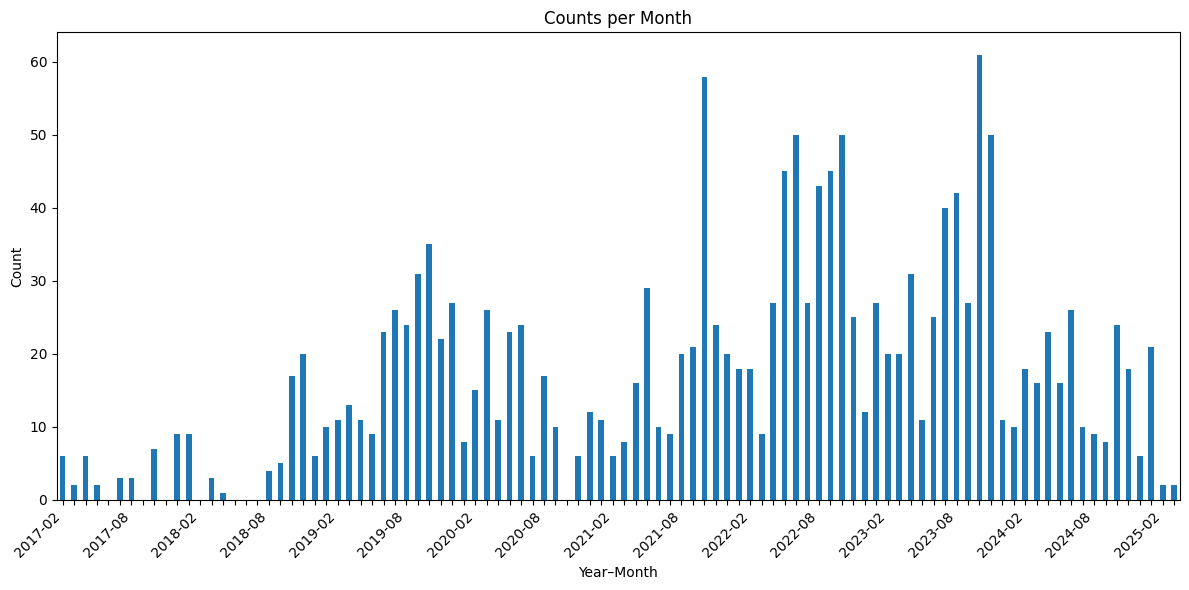

In [21]:
# --- Params ---
nth = 6  # show every nth month label

# If you already have 'year' and 'month' cols:
period = pd.PeriodIndex(year=ss_labels["year"], month=ss_labels["month"], freq="M")

# Counts per month (sorted)
counts = period.value_counts().sort_index()

# Fill missing months between start and end
full = pd.period_range(counts.index.min(), counts.index.max(), freq="M")
counts = counts.reindex(full, fill_value=0)

# Plot
ax = counts.plot(kind="bar", figsize=(12, 6))
ax.set_xlabel("Year–Month")
ax.set_ylabel("Count")
ax.set_title("Counts per Month")

# Only label every nth month for readability
labels = [p.strftime("%Y-%m") for p in counts.index]
for i, label in enumerate(ax.get_xticklabels()):
    label.set_visible(i % nth == 0)

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [22]:
for region, rdf in ss_labels.groupby("region"):
    ddf = empa_labels[empa_labels["Site code"] == region]
    if not len(ddf):
        continue

    ddf = ddf.sort_values("samplecollectiondate").reset_index(drop=True)
    rdf = rdf.sort_values("acquired").reset_index(drop=True)

    # Nearest match within n days
    pairs = pd.merge_asof(
        ddf,
        rdf,
        left_on="samplecollectiondate",
        right_on="acquired",
        direction="nearest",
        tolerance=pd.Timedelta("2D"),
        suffixes=("_d", "_r"),
    )
    pairs = pairs[~pairs.region.isna()]
    if len(pairs):
        print(pairs[["Site code", "estuaryname", "samplecollectiondate", "mouth_closed", "label"]])

   Site code   estuaryname      samplecollectiondate  mouth_closed label
1         51  Pajaro River 2023-10-24 19:00:00+00:00         False  open


In [23]:
ss_empa_labels = ss_labels.copy()
ss_empa_labels["source"] = "skysat"
to_add = []
for _, row in empa_labels.iterrows():
    to_add.append(
        {
            "region": row["Site code"],
            "label": "closed" if row.mouth_closed else "open",
            "source": "empa",
            "acquired": row.samplecollectiondate,
        }
    )
ss_empa_labels = pd.concat([ss_empa_labels, pd.DataFrame(to_add)])
# ss_empa_labels.to_csv("/Volumes/x10pro/estuary/skysat/labels_empa.csv")
ss_empa_labels.head()

,region,source_tif,source_jpeg,label,acquired,instrument,year,month,source
0,35,/Volumes/x10pro/estuary/skysat/results/2022/35...,/Volumes/x10pro/estuary/ca_labeling/00053/imag...,closed,2022-06-15 18:07:04+00:00,skysat,2022.0,6.0,skysat
1,35,/Volumes/x10pro/estuary/skysat/results/2023/35...,/Volumes/x10pro/estuary/ca_labeling/00053/imag...,open,2023-04-02 21:21:05+00:00,skysat,2023.0,4.0,skysat
2,35,/Volumes/x10pro/estuary/skysat/results/2019/35...,/Volumes/x10pro/estuary/ca_labeling/00053/imag...,open,2019-06-08 18:38:26+00:00,skysat,2019.0,6.0,skysat
3,35,/Volumes/x10pro/estuary/skysat/results/2019/35...,/Volumes/x10pro/estuary/ca_labeling/00053/imag...,closed,2019-11-02 21:40:24+00:00,skysat,2019.0,11.0,skysat
4,35,/Volumes/x10pro/estuary/skysat/results/2021/35...,/Volumes/x10pro/estuary/ca_labeling/00053/imag...,closed,2021-05-29 18:42:34+00:00,skysat,2021.0,5.0,skysat


In [24]:
dove = []
for base in [
    Path("/Volumes/x10pro/estuary/dove/results"),
    Path("/Volumes/x10pro/estuary/superdove/results"),
]:
    for pth in base.glob("*/*/*/images_to_download.csv"):
        df = pd.read_csv(pth).drop(columns=["ordered_idx"])
        df["region"] = int(pth.parent.name)
        df["capture_datetime"] = pd.to_datetime(
            df["capture_datetime"], errors="coerce"
        ).dt.tz_localize("UTC")  # interpret naive times as already UTC
        df["dove"] = base.parent.name
        dove.append(df)

dove_df = pd.concat(dove)

# Add ISO year and ISO week
dove_df["year"] = dove_df.capture_datetime.dt.year
dove_df["month"] = dove_df.capture_datetime.dt.month
dove_df["week"] = dove_df.capture_datetime.dt.isocalendar().week
dove_df["week2"] = dove_df.capture_datetime.dt.isocalendar().week // 2

dove_df = dove_df[dove_df.include_image]

print(len(dove_df))

dove_df.head()

108011


,asset_id,clear_coverge_pct,intersection_pct,pct_adding,capture_datetime,include_image,region,dove,year,month,week,week2
0,20220131_180804_75_1067,0.999202,1.0,99.920217,2022-01-31 18:08:04+00:00,True,61,dove,2022,1,5,2
1,20220129_183147_1038,0.999202,1.0,99.920217,2022-01-29 18:31:47+00:00,True,61,dove,2022,1,4,2
2,20220126_183109_44_105c,0.999202,1.0,99.920217,2022-01-26 18:31:09+00:00,True,61,dove,2022,1,4,2
3,20220121_182719_1014,0.999202,1.0,99.920217,2022-01-21 18:27:19+00:00,True,61,dove,2022,1,3,1
4,20220120_182823_1035,0.999202,1.0,99.920217,2022-01-20 18:28:23+00:00,True,61,dove,2022,1,3,1


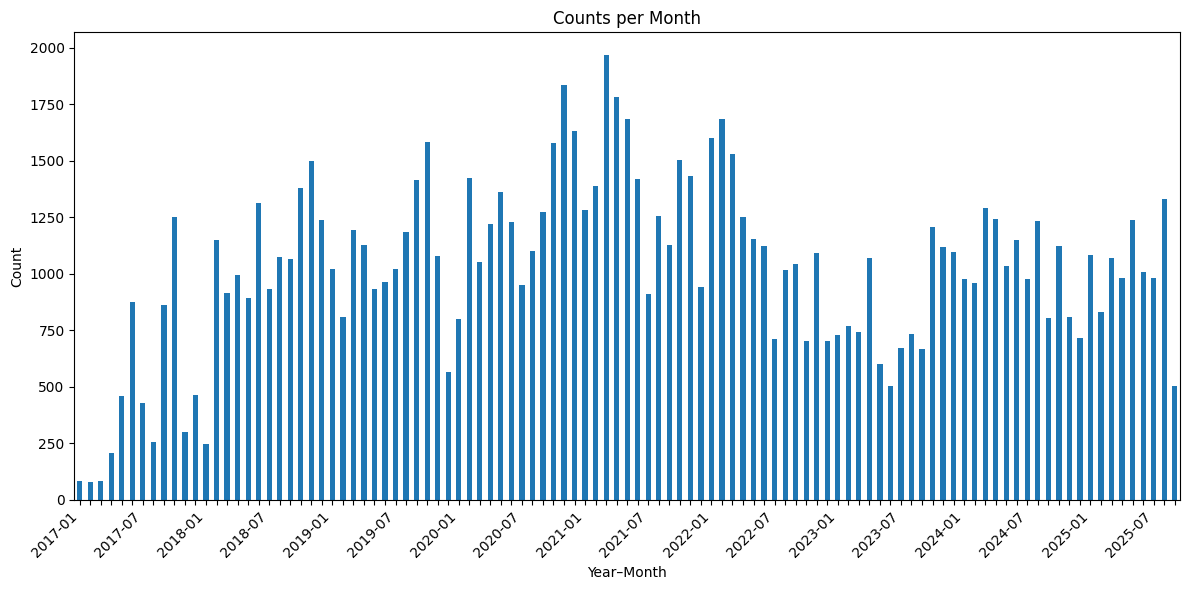

In [25]:
# --- Params ---
nth = 6  # show every nth month label

# If you already have 'year' and 'month' cols:
period = pd.PeriodIndex.from_fields(year=dove_df["year"], month=dove_df["month"], freq="M")

# Counts per month (sorted)
counts = period.value_counts().sort_index()

# Fill missing months between start and end
full = pd.period_range(counts.index.min(), counts.index.max(), freq="M")
counts = counts.reindex(full, fill_value=0)

# Plot
ax = counts.plot(kind="bar", figsize=(12, 6))
ax.set_xlabel("Year–Month")
ax.set_ylabel("Count")
ax.set_title("Counts per Month")

# Only label every nth month for readability
labels = [p.strftime("%Y-%m") for p in counts.index]
for i, label in enumerate(ax.get_xticklabels()):
    label.set_visible(i % nth == 0)

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [26]:
ss_empa_labels = (
    ss_empa_labels[ss_empa_labels.label != "unsure"].sort_values("acquired").reset_index(drop=True)
)
dove_df = dove_df.sort_values("capture_datetime").reset_index(drop=True)

tol = pd.Timedelta("28h")

# cross-join within region, then filter by window
tmp = dove_df.merge(ss_empa_labels, on="region", suffixes=("_dd", "_ss"))
mask = (tmp["acquired"] >= tmp["capture_datetime"] - tol) & (
    tmp["acquired"] <= tmp["capture_datetime"] + tol
)
pairs = tmp.loc[mask].sort_values(["region", "capture_datetime", "acquired"])

pairs = pairs.drop(columns=["year_ss", "month_ss"]).rename(
    columns={"year_dd": "year", "month_dd": "month"}
)
# pairs = pd.merge_asof(
#     dove_df,
#     ss_empa_labels,
#     by="region",
#     right_on="acquired",
#     left_on="capture_datetime",
#     direction="nearest",
#     tolerance=pd.Timedelta("28h"),
#     suffixes=("_dd", "_ss"),
# )
# pairs = pairs[~pairs.source_tif.isna()]
len(pairs)

2270

In [27]:
pairs.head()

,asset_id,clear_coverge_pct,intersection_pct,pct_adding,capture_datetime,include_image,region,dove,year,month,week,week2,source_tif,source_jpeg,label,acquired,instrument,source
381193,20190308_175927_0e0e,1.007112,1.0,100.711209,2019-03-08 17:59:27+00:00,True,11,dove,2019,3,10,5,/Volumes/x10pro/estuary/skysat/results/2019/11...,/Volumes/x10pro/estuary/ca_labeling/00065/imag...,open,2019-03-09 21:24:04+00:00,skysat,skysat
382432,20190310_172726_1053,1.007112,1.0,100.711209,2019-03-10 17:27:26+00:00,True,11,dove,2019,3,10,5,/Volumes/x10pro/estuary/skysat/results/2019/11...,/Volumes/x10pro/estuary/ca_labeling/00065/imag...,open,2019-03-09 21:24:04+00:00,skysat,skysat
724436,20200801_161237_0f2e,1.007112,1.0,100.711209,2020-08-01 16:12:37+00:00,True,11,dove,2020,8,31,15,/Volumes/x10pro/estuary/skysat/results/2020/11...,/Volumes/x10pro/estuary/ca_labeling/00065/imag...,open,2020-08-01 18:45:36+00:00,skysat,skysat
727193,20200805_181028_1035,1.007112,1.0,100.711209,2020-08-05 18:10:28+00:00,True,11,dove,2020,8,32,16,/Volumes/x10pro/estuary/skysat/results/2020/11...,/Volumes/x10pro/estuary/ca_labeling/00065/imag...,open,2020-08-06 21:26:39+00:00,skysat,skysat
727738,20200806_175246_0e26,1.007112,1.0,100.711209,2020-08-06 17:52:46+00:00,True,11,dove,2020,8,32,16,/Volumes/x10pro/estuary/skysat/results/2020/11...,/Volumes/x10pro/estuary/ca_labeling/00065/imag...,open,2020-08-06 21:26:39+00:00,skysat,skysat


In [28]:
pairs_dedup = pairs.sort_values(
    by=["region", "year", "month", "dove", "label", "source"],
    ascending=[True, True, True, False, True, True],
).drop_duplicates(["region", "year", "month", "label"])

len(pairs_dedup)

808

In [29]:
len(pairs_dedup[pairs_dedup.source == "empa"])

40

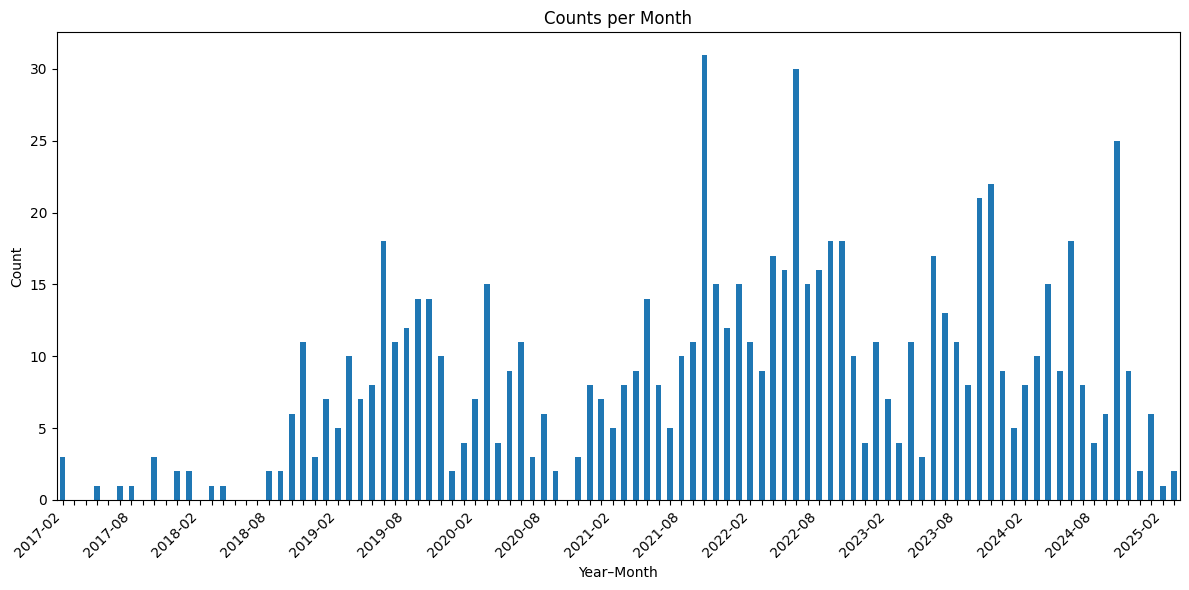

In [30]:
# --- Params ---
nth = 6  # show every nth month label

# If you already have 'year' and 'month' cols:
period = pd.PeriodIndex.from_fields(year=pairs_dedup["year"], month=pairs_dedup["month"], freq="M")

# Counts per month (sorted)
counts = period.value_counts().sort_index()

# Fill missing months between start and end
full = pd.period_range(counts.index.min(), counts.index.max(), freq="M")
counts = counts.reindex(full, fill_value=0)

# Plot
ax = counts.plot(kind="bar", figsize=(12, 6))
ax.set_xlabel("Year–Month")
ax.set_ylabel("Count")
ax.set_title("Counts per Month")

# Only label every nth month for readability
labels = [p.strftime("%Y-%m") for p in counts.index]
for i, label in enumerate(ax.get_xticklabels()):
    label.set_visible(i % nth == 0)

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

num missed regions 2


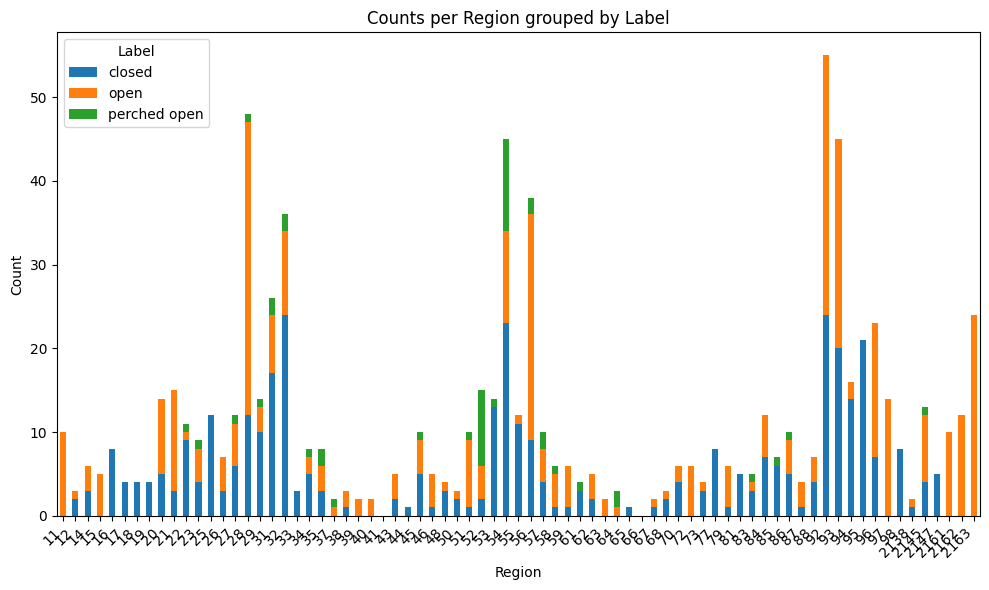

In [31]:
missed_regions = set(rect_df["Site code"].unique()) - set(pairs_dedup.region.unique())

print("num missed regions", len(missed_regions))

# Group by region and label, then count rows
counts = pairs_dedup.groupby(["region", "label"]).size().unstack(fill_value=0)

all_regions = counts.index.union(missed_regions)

counts = counts.reindex(all_regions, fill_value=0)

# Plot stacked bar chart
counts.plot(kind="bar", stacked=True, figsize=(10, 6))

plt.xlabel("Region")
plt.ylabel("Count")
plt.title("Counts per Region grouped by Label")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Label")
plt.tight_layout()
plt.show()

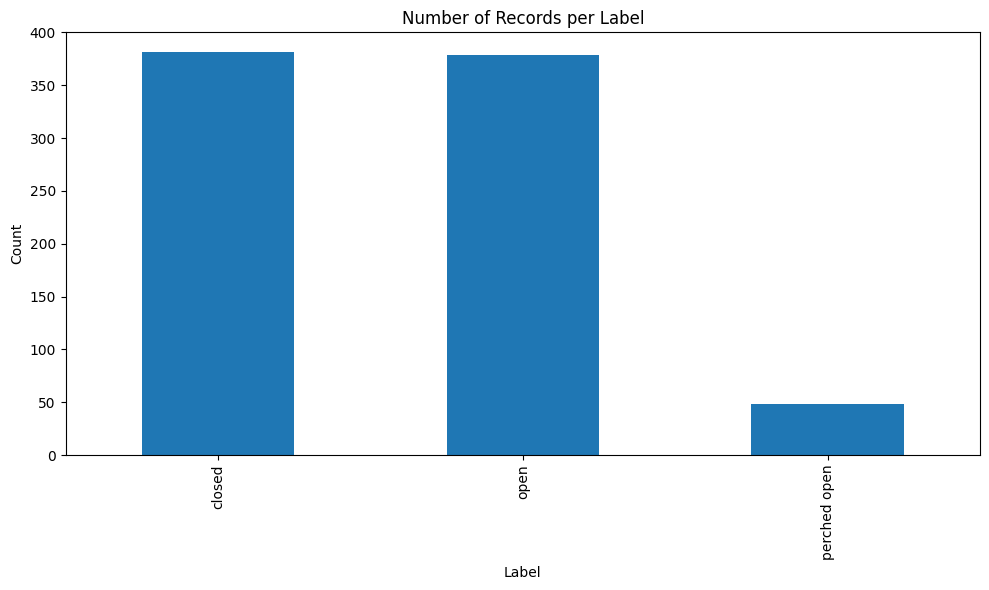

In [32]:
counts = pairs_dedup["label"].value_counts()

# Plot as bar chart
counts.plot(kind="bar", figsize=(10, 6))
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Number of Records per Label")
plt.tight_layout()
plt.show()

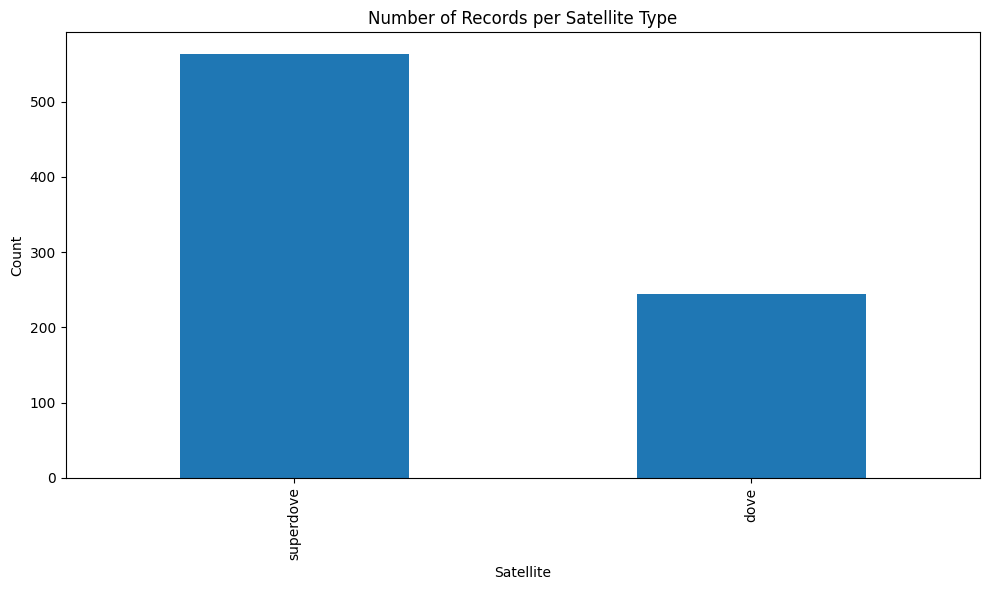

In [33]:
counts = pairs_dedup["dove"].value_counts()

# Plot as bar chart
counts.plot(kind="bar", figsize=(10, 6))
plt.xlabel("Satellite")
plt.ylabel("Count")
plt.title("Number of Records per Satellite Type")
plt.tight_layout()
plt.show()

In [34]:
pairs_dedup["source"].value_counts()

source
skysat    768
empa       40
Name: count, dtype: int64

In [35]:
to_download = []
for (region, month, year), df in dove_df.groupby(["region", "month", "year"]):
    super_label_df = pairs_dedup[
        (pairs_dedup.region == region) & (pairs_dedup.year == year) & (pairs_dedup.month == month)
    ]
    if len(super_label_df):
        to_download.append(super_label_df[["region", "year", "month", "asset_id", "dove"]])
    else:
        to_download.append(df[["region", "year", "month", "asset_id", "dove"]].iloc[0:1])

to_download = (
    pd.concat(to_download)
    .sort_values(["region", "year", "month", "dove", "asset_id"])
    .reset_index(drop=True)
)

print(len(to_download))
to_download.head()

9142


,region,year,month,asset_id,dove
0,11,2017,1,20170113_174458_0e0e,dove
1,11,2017,2,20170201_174604_0e30,dove
2,11,2017,3,20170303_174732_0e3a,dove
3,11,2017,4,20170405_174111_1038,dove
4,11,2017,5,20170513_174245_0f52,dove


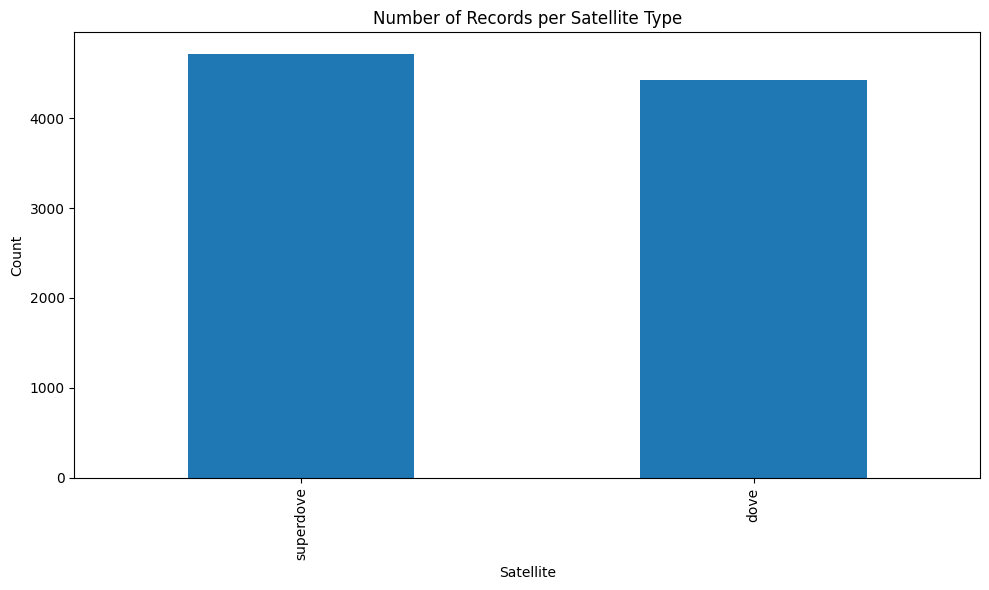

In [36]:
counts = to_download["dove"].value_counts()

# Plot as bar chart
counts.plot(kind="bar", figsize=(10, 6))
plt.xlabel("Satellite")
plt.ylabel("Count")
plt.title("Number of Records per Satellite Type")
plt.tight_layout()
plt.show()

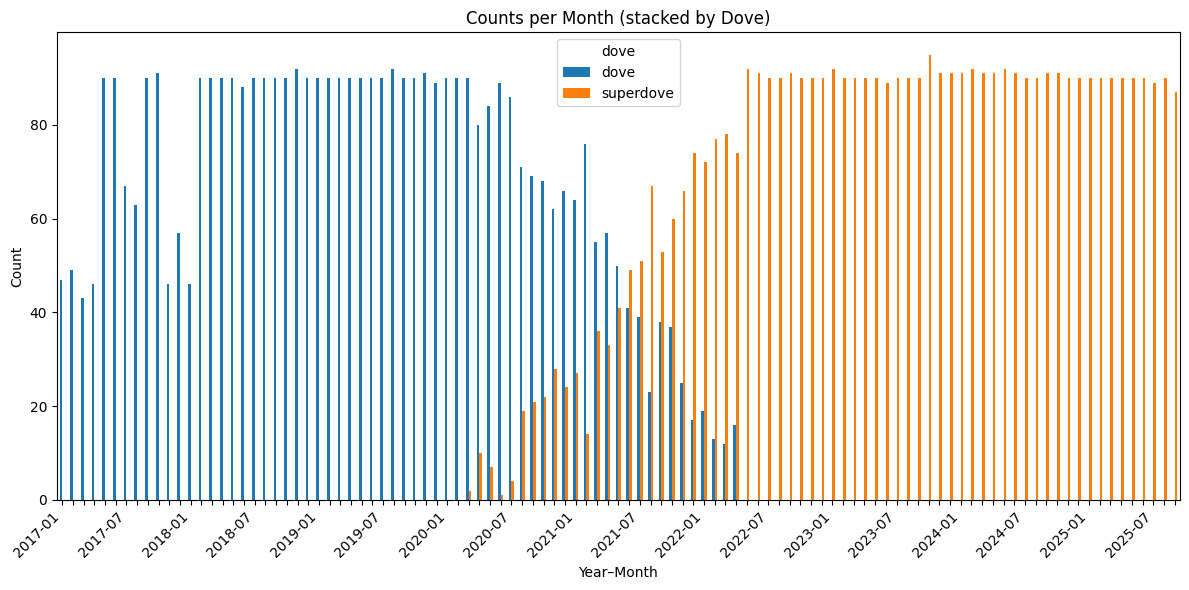

In [37]:
# --- Params ---
nth = 6  # show every nth month label

# If you already have 'year' and 'month' cols:
# If you already have capture_datetime, easiest is to make a period column
to_download["period"] = pd.PeriodIndex.from_fields(
    year=to_download["year"], month=to_download["month"], freq="M"
)

# Group by month + dove, then unstack to make dove the stacked key
counts = to_download.groupby(["period", "dove"]).size().unstack(fill_value=0).sort_index()

# Fill in missing months across the full range
full = pd.period_range(counts.index.min(), counts.index.max(), freq="M")
counts = counts.reindex(full, fill_value=0)

# Plot
ax = counts.plot(kind="bar", figsize=(12, 6))
ax.set_xlabel("Year–Month")
ax.set_ylabel("Count")
ax.set_title("Counts per Month (stacked by Dove)")

# Sparse tick labels
for i, label in enumerate(ax.get_xticklabels()):
    label.set_visible(i % nth == 0)

plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

num missed regions 0


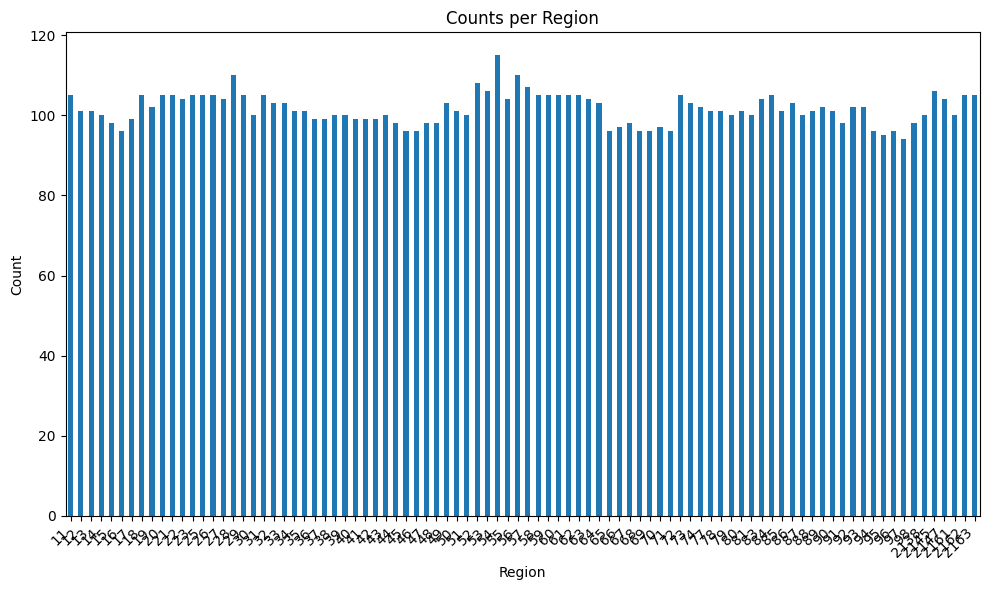

In [38]:
missed_regions = set(rect_df["Site code"].unique()) - set(to_download.region.unique())

print("num missed regions", len(missed_regions))

# Group by region and label, then count rows
counts = to_download.region.value_counts()

all_regions = counts.index.union(missed_regions)

counts = counts.reindex(all_regions, fill_value=0).sort_index()

# Plot stacked bar chart
counts.plot(kind="bar", figsize=(10, 6))

plt.xlabel("Region")
plt.ylabel("Count")
plt.title("Counts per Region")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

num missed regions 0


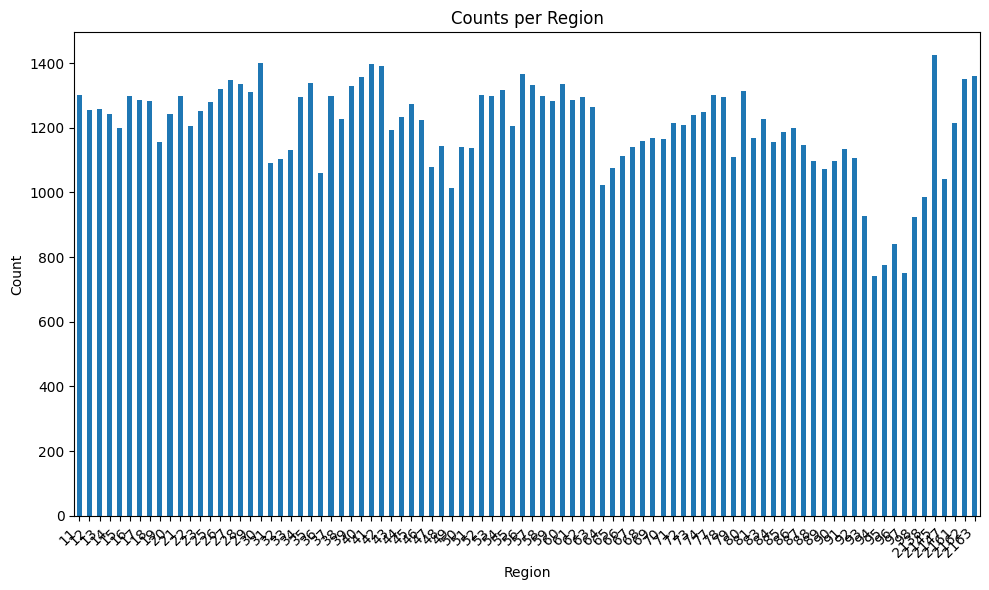

In [39]:
missed_regions = set(rect_df["Site code"].unique()) - set(dove_df.region.unique())

print("num missed regions", len(missed_regions))

# Group by region and label, then count rows
counts = dove_df.region.value_counts()

all_regions = counts.index.union(missed_regions)

counts = counts.reindex(all_regions, fill_value=0).sort_index()

# Plot stacked bar chart
counts.plot(kind="bar", figsize=(10, 6))

plt.xlabel("Region")
plt.ylabel("Count")
plt.title("Counts per Region")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [40]:
# base = Path("/Volumes/x10pro/estuary/")
# for (region, year, month, dove), df in to_download.groupby(["region", "year", "month", "dove"]):
#     df = df[["asset_id"]].copy()
#     if not len(df):
#         continue
#     df["include_image"] = True

#     save_path = base / dove / "results" / str(year) / str(month) / str(region) / "subset_images_to_download.csv"
#     assert save_path.parent.exists()
#     df.to_csv(save_path)


In [41]:
d_df = pd.read_csv("/Volumes/x10pro/estuary/dove/labels.csv")
d_df["acquired"] = pd.to_datetime(d_df["acquired"], errors="coerce").dt.tz_localize(
    "UTC"
)  # interpret naive times as already UTC
d_df["year"] = d_df.acquired.dt.year
d_df["month"] = d_df.acquired.dt.month
d_df = d_df[d_df["label"] != "unsure"].copy()
d_df = d_df[~d_df.region.isin(skipped)].copy()

print("Num Regions:", len(d_df.region.unique()), "Num images:", len(d_df))
d_df.head()

Num Regions: 75 Num images: 7021


,region,source_tif,source_jpeg,label,acquired,instrument,year,month
0,65,/Volumes/x10pro/estuary/superdove/results/2022...,/Volumes/x10pro/estuary/dove/labeling/00204/im...,closed,2022-09-03 18:37:27+00:00,dove,2022,9
1,65,/Volumes/x10pro/estuary/superdove/results/2022...,/Volumes/x10pro/estuary/dove/labeling/00204/im...,closed,2022-11-02 18:35:56+00:00,dove,2022,11
2,65,/Volumes/x10pro/estuary/superdove/results/2022...,/Volumes/x10pro/estuary/dove/labeling/00204/im...,closed,2022-07-10 18:21:59+00:00,dove,2022,7
3,65,/Volumes/x10pro/estuary/superdove/results/2022...,/Volumes/x10pro/estuary/dove/labeling/00204/im...,closed,2022-06-09 18:05:19+00:00,dove,2022,6
4,65,/Volumes/x10pro/estuary/superdove/results/2022...,/Volumes/x10pro/estuary/dove/labeling/00204/im...,closed,2022-01-01 18:06:34+00:00,dove,2022,1


num missed regions 0


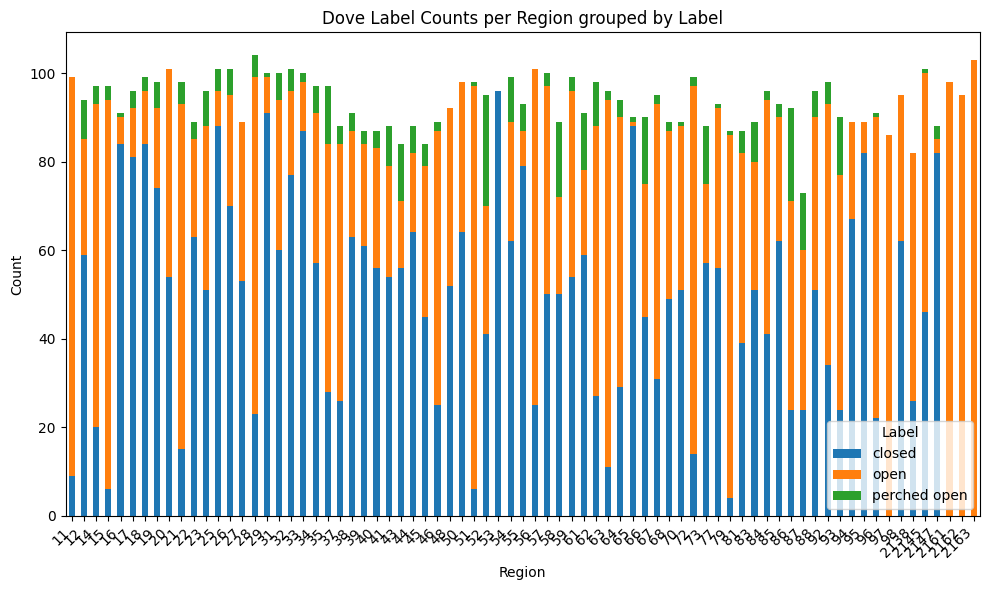

In [42]:
missed_regions = set(rect_df["Site code"].unique()) - set(d_df.region.unique())

print("num missed regions", len(missed_regions))

# Group by region and label, then count rows
counts = d_df.groupby(["region", "label"]).size().unstack(fill_value=0)

all_regions = counts.index.union(missed_regions)

counts = counts.reindex(all_regions, fill_value=0)

# Plot stacked bar chart
counts.plot(kind="bar", stacked=True, figsize=(10, 6))

plt.xlabel("Region")
plt.ylabel("Count")
plt.title("Dove Label Counts per Region grouped by Label")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Label")
plt.tight_layout()
plt.show()

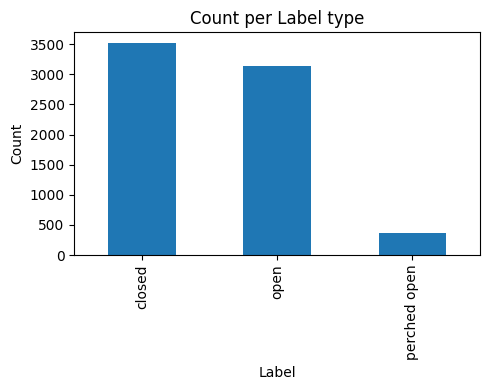

In [43]:
counts = d_df.label.value_counts()

# Plot as bar chart
counts.plot(kind="bar", figsize=(5, 4))
plt.xlabel("Label")
plt.ylabel("Count")
plt.title("Count per Label type")
plt.tight_layout()
plt.show()

In [53]:
ss_empa_labels[(~ss_empa_labels.source_tif.isna())].region.unique().size

72

In [54]:
tmp = d_df.merge(ss_empa_labels, on="region", suffixes=("_dd", "_ss"))
tol = pd.Timedelta("14h")
mask = (tmp["acquired_dd"] >= tmp["acquired_ss"] - tol) & (
    tmp["acquired_dd"] <= tmp["acquired_ss"] + tol
)
dove_pairs = tmp.loc[mask].sort_values(["region", "acquired_dd", "acquired_ss"])

dove_pairs = dove_pairs.drop(columns=["year_ss", "month_ss"]).rename(
    columns={"year_dd": "year", "month_dd": "month"}
)

print(len(dove_pairs))

dove_pairs.head()

346


,region,source_tif_dd,source_jpeg_dd,label_dd,acquired_dd,instrument_dd,year,month,source_tif_ss,source_jpeg_ss,label_ss,acquired_ss,instrument_ss,source
137840,11,/Volumes/x10pro/estuary/dove/results/2020/8/11...,/Volumes/x10pro/estuary/dove/labeling/00139/im...,open,2020-08-01 16:12:37+00:00,dove,2020,8,/Volumes/x10pro/estuary/skysat/results/2020/11...,/Volumes/x10pro/estuary/ca_labeling/00065/imag...,open,2020-08-01 18:45:36+00:00,skysat,skysat
137268,11,/Volumes/x10pro/estuary/superdove/results/2021...,/Volumes/x10pro/estuary/dove/labeling/00139/im...,open,2021-11-10 17:53:44+00:00,dove,2021,11,/Volumes/x10pro/estuary/skysat/results/2021/11...,/Volumes/x10pro/estuary/ca_labeling/00065/imag...,open,2021-11-10 21:35:51+00:00,skysat,skysat
136598,11,/Volumes/x10pro/estuary/superdove/results/2022...,/Volumes/x10pro/estuary/dove/labeling/00139/im...,open,2022-06-23 18:08:38+00:00,dove,2022,6,/Volumes/x10pro/estuary/skysat/results/2022/11...,/Volumes/x10pro/estuary/ca_labeling/00065/imag...,open,2022-06-24 01:30:52+00:00,skysat,skysat
137111,11,/Volumes/x10pro/estuary/superdove/results/2023...,/Volumes/x10pro/estuary/dove/labeling/00139/im...,open,2023-06-29 17:39:07+00:00,dove,2023,6,/Volumes/x10pro/estuary/skysat/results/2023/11...,/Volumes/x10pro/estuary/ca_labeling/00065/imag...,open,2023-06-29 21:52:17+00:00,skysat,skysat
125741,12,/Volumes/x10pro/estuary/superdove/results/2021...,/Volumes/x10pro/estuary/dove/labeling/00140/im...,open,2021-12-15 17:38:36+00:00,dove,2021,12,/Volumes/x10pro/estuary/skysat/results/2021/12...,/Volumes/x10pro/estuary/ca_labeling/00104/imag...,open,2021-12-15 17:59:37+00:00,skysat,skysat


In [45]:
dove_pairs.label_dd.unique()

array(['open', 'closed', 'perched open'], dtype=object)

Accuracy 89.8


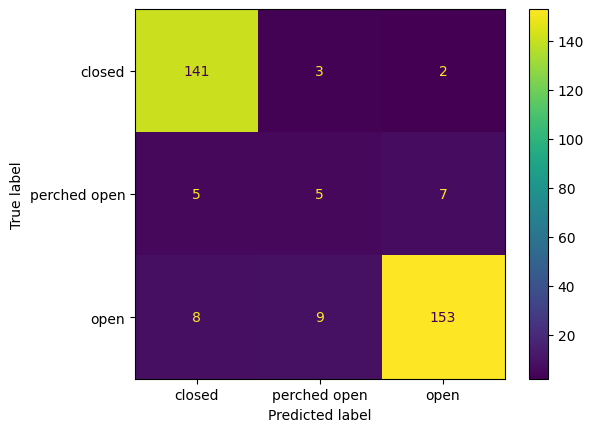

In [60]:
labels = ["closed", "perched open", "open"]
aaa = dove_pairs[dove_pairs.source != "empa"]
y_true = [labels.index(l) for l in aaa.label_ss]
y_pred = [labels.index(l) for l in aaa.label_dd]

print("Accuracy", round(100 * accuracy_score(y_true, y_pred), 1))

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels)

Accuracy 94.6


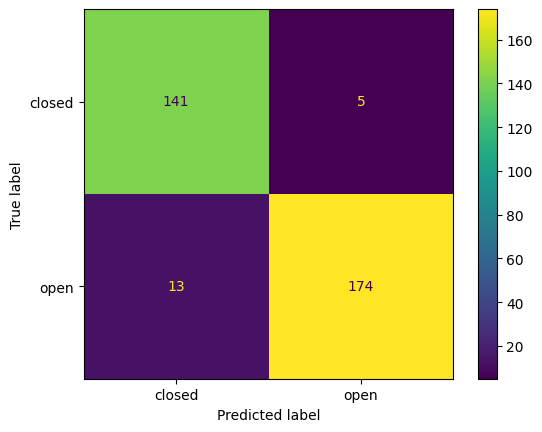

In [61]:
labels = ["closed", "open"]
aaa = dove_pairs[dove_pairs.source != "empa"]
y_true = [int("open" in l) for l in aaa.label_ss]
y_pred = [int("open" in l) for l in aaa.label_dd]

print("Accuracy", round(100 * accuracy_score(y_true, y_pred), 1))

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels)

Accuracy 84.6


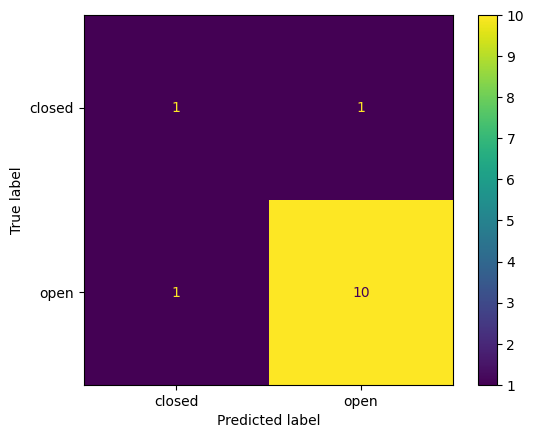

In [62]:
aaa = dove_pairs[dove_pairs.source == "empa"]
labels = ["closed", "open"]
y_true = [int("open" in l) for l in aaa.label_ss]
y_pred = [int("open" in l) for l in aaa.label_dd]

print("Accuracy", round(100 * accuracy_score(y_true, y_pred), 1))

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=labels)

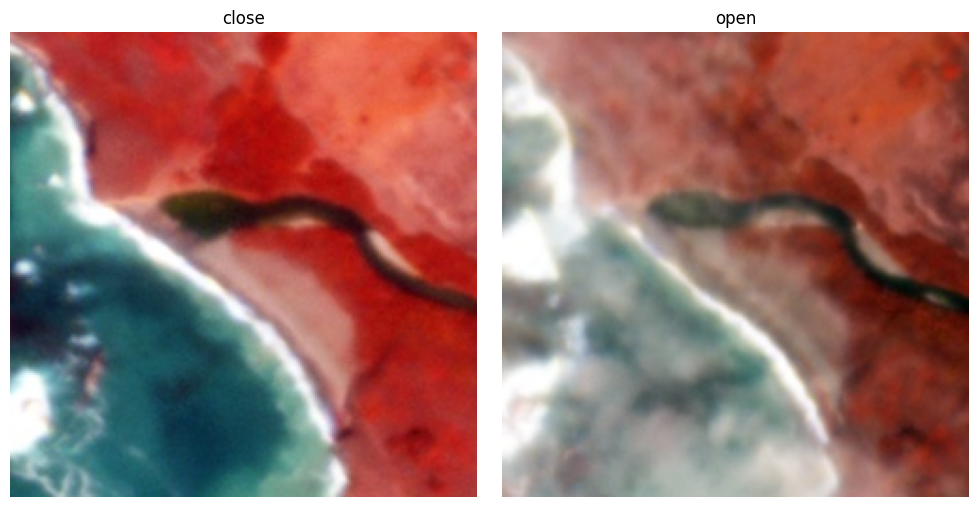

In [63]:
empa_closed = dove_pairs[
    (dove_pairs.source == "empa")
    & (dove_pairs.label_dd != "closed")
    & (dove_pairs.label_ss == "closed")
]
empa_open = dove_pairs[
    (dove_pairs.source == "empa")
    & (dove_pairs.label_dd == "closed")
    & (dove_pairs.label_ss != "closed")
]

fig, axes = plt.subplots(ncols=2, nrows=len(empa_open), figsize=(10, 5 * len(empa_open)))
if len(axes.shape) == 1:
    axes = [axes]

for i, (_, row) in enumerate(empa_closed.iterrows()):
    axes[i][0].axis("off")
    axes[i][0].imshow(Image.open(row.source_jpeg_dd))
    if i == 0:
        axes[i][0].set_title("close")

for i, (_, row) in enumerate(empa_open.iterrows()):
    axes[i][1].axis("off")
    axes[i][1].imshow(Image.open(row.source_jpeg_dd))
    if i == 0:
        axes[i][1].set_title("open")

fig.tight_layout()
plt.show()

In [50]:
# inspect = dove_pairs[
#     ((
#         (dove_pairs.label_ss == "closed") &
#         (dove_pairs.label_dd != "closed")
#     ) |
#     (
#         (dove_pairs.label_ss != "closed") &
#         (dove_pairs.label_dd == "closed")
#     )) &
#     (dove_pairs.source == "skysat")
# ]

# save_path = Path("/Volumes/x10pro/estuary/inspect_28")
# save_path.mkdir(exist_ok=True, parents=True)
# for _, row in inspect.iterrows():
#     region = row.region
#     year = row.year
#     month = row.month

#     with rasterio.open(row.source_tif_dd) as src:
#         data = src.read(out_dtype=np.float32)
#         nodata = src.read(1, masked=True).mask
#         if len(data) == 4:
#             img = false_color(data, nodata)
#         else:
#             img = broad_band(data, nodata)
#         dd_img = Image.fromarray(img)

#     with rasterio.open(row.source_tif_ss) as src:
#         data = src.read(out_dtype=np.float32)
#         nodata = src.read(1, masked=True).mask
#         if len(data) == 4:
#             img = false_color(data, nodata)
#         else:
#             img = broad_band(data, nodata)
#         ss_img = Image.fromarray(img)

#     dd_img = dd_img.resize(ss_img.size)

#     # You can load a TTF font; fallback to default
#     try:
#         font = ImageFont.truetype("arial.ttf", 72)
#     except IOError:
#         font = ImageFont.load_default(72)

#     # Top-right for first image
#     # Draw text (top-right corner of each)
#     draw = ImageDraw.Draw(ss_img)
#     text1 = "-".join(row.label_ss.split(" "))
#     w1 = draw.textlength(text1, font=font)
#     draw.text((ss_img.width - w1 - 5, 5), text1, fill="white", font=font)

#     # Top-right for second image
#     draw = ImageDraw.Draw(dd_img)
#     text2 = "-".join(row.label_dd.split(" "))
#     w2 = draw.textlength(text2, font=font)
#     draw.text((dd_img.width - w2 - 5, 5), text2, fill="white", font=font)

#     # Concatenate horizontally
#     total_width = ss_img.width + ss_img.width
#     max_height = max(ss_img.height, ss_img.height)
#     new_im = Image.new("RGB", (total_width, max_height))

#     new_im.paste(ss_img, (0, 0))
#     new_im.paste(dd_img, (ss_img.width, 0))

#     # Save
#     new_im.save(save_path / f"{region}_{year}-{month}_{text1}.png")

In [68]:
gdf["empa_site_id"] = None
for region, _ in gdf.iterrows():
    gdf.loc[region, "empa_site_id"] = matching_sites.get(region)

label_pcts = d_df.groupby("region")["label"].value_counts(normalize=True).unstack(fill_value=0)
label_pcts.index.name = "Site code"

labeled_gdf = gdf.join(label_pcts)

labeled_gdf.head(5)

,Latitude,Longitude,Region,Nation,Site name,Studied (1) / Not Studied (0),station_nm,site_no,site_latitude,site_longitude,geometry,empa_site_id,closed,open,perched open
Site code,,,,,,,,,,,,,,,
11,32.933,-117.260,North America,USA,Los Penasquitos Lagoon,1,None,None,None,None,POINT (-117.26 32.933),SC-LPL,0.090909,0.909091,0.000000
12,33.166,-117.358,North America,USA,Buena Vista Lagoon,0,None,None,None,None,POINT (-117.358 33.166),None,0.627660,0.276596,0.095745
14,33.203,-117.391,North America,USA,San Luis Rey River,0,None,None,None,None,POINT (-117.391 33.203),None,0.206186,0.752577,0.041237
15,33.231,-117.416,North America,USA,Santa Margarita River,1,SANTA MARGARITA RIVER ESTUARY NR OCEANSIDE CA,11046050,33.2294795,-117.4103174,POINT (-117.416 33.231),None,0.061856,0.907216,0.030928
16,33.291,-117.465,North America,USA,Las Fores Creek,0,LAS FLORES C LAGOON A MOUTH NR OCEANSIDE CA,11046102,33.29055556,-117.465,POINT (-117.465 33.291),None,0.923077,0.065934,0.010989


In [52]:
labeled_gdf[~labeled_gdf.empa_site_id.isna() & ~labeled_gdf.station_nm.isna()]

,Latitude,Longitude,Region,Nation,Site name,Studied (1) / Not Studied (0),station_nm,site_no,site_latitude,site_longitude,geometry,empa_site_id,closed,open,perched open
Site code,,,,,,,,,,,,,,,
72,38.451,-123.128,North America,USA,Russian River,1,RUSSIAN R A HIGHWAY 1 BRIDGE NR JENNER CA,11467270,38.4340222,-123.1011083,POINT (-123.128 38.451),NC-RUSR,0.141414,0.838384,0.020202


In [53]:
TEST_SITES = [72]
VAL_SITES = []
TRAIN_SITES = []

In [54]:
labeled_gdf[~labeled_gdf.empa_site_id.isna()]

,Latitude,Longitude,Region,Nation,Site name,Studied (1) / Not Studied (0),station_nm,site_no,site_latitude,site_longitude,geometry,empa_site_id,closed,open,perched open
Site code,,,,,,,,,,,,,,,
11,32.933000,-117.260000,North America,USA,Los Penasquitos Lagoon,1,None,None,None,None,POINT (-117.26 32.933),SC-LPL,0.090909,0.909091,0.000000
18,34.015000,-118.821000,North America,USA,Zuma Lagoon,0,None,None,None,None,POINT (-118.821 34.015),SC-ZUM,0.848485,0.121212,0.030303
21,34.276000,-119.308000,North America,USA,Ventura River,0,None,None,None,None,POINT (-119.308 34.276),SC-VEN,0.153061,0.795918,0.051020
25,34.411000,-119.881000,North America,USA,Deveereux Slough,1,None,None,None,None,POINT (-119.881 34.411),SC-DEV,0.871287,0.079208,0.049505
28,34.417000,-119.828000,North America,USA,San Pedro Creek,0,None,None,None,None,POINT (-119.828 34.417),SC-GOL,0.221154,0.730769,0.048077
43,35.710000,-121.310000,North America,USA,Arroyo De La Laguna,0,None,None,None,None,POINT (-121.31 35.71),CC-ADLC,0.666667,0.178571,0.154762
48,36.537000,-121.927000,North America,USA,Carmel River,1,None,None,None,None,POINT (-121.927 36.537),CC-CAR,0.565217,0.434783,0.000000
50,36.748000,-121.801000,North America,USA,Salinas River,1,None,None,None,None,POINT (-121.801 36.748),CC-SALI,0.653061,0.346939,0.000000
51,36.852000,-121.809000,North America,USA,Pajaro River,0,None,None,None,None,POINT (-121.809 36.852),CC-PAJ,0.061224,0.928571,0.010204


In [55]:
TEST_SITES.extend([11, 18, 48, 50])
VAL_SITES.extend([21, 25, 51, 2145])
TRAIN_SITES.extend([28, 43, 84, 2161, 2162, 2163])

In [56]:
labeled_gdf[~labeled_gdf.site_no.isna()]

,Latitude,Longitude,Region,Nation,Site name,Studied (1) / Not Studied (0),station_nm,site_no,site_latitude,site_longitude,geometry,empa_site_id,closed,open,perched open
Site code,,,,,,,,,,,,,,,
15,33.231000,-117.416000,North America,USA,Santa Margarita River,1,SANTA MARGARITA RIVER ESTUARY NR OCEANSIDE CA,11046050,33.2294795,-117.4103174,POINT (-117.416 33.231),None,0.061856,0.907216,0.030928
16,33.291000,-117.465000,North America,USA,Las Fores Creek,0,LAS FLORES C LAGOON A MOUTH NR OCEANSIDE CA,11046102,33.29055556,-117.465,POINT (-117.465 33.291),None,0.923077,0.065934,0.010989
17,33.386000,-117.594000,North America,USA,San Mateo Creek,0,SAN MATEO C LAGOON A MOUTH NR SAN CLEMENTE CA,11046325,33.38666667,-117.5938889,POINT (-117.594 33.386),None,0.843750,0.114583,0.041667
27,34.413000,-119.687000,North America,USA,Mission Creek,0,MISSION C BL W GUTIERREZ ST BR A SANTA BARBARA CA,11119770,34.41421944,-119.6958472,POINT (-119.687 34.413),None,0.595506,0.404494,0.000000
56,36.965000,-122.013000,North America,USA,San Lorenzo River,0,SAN LORENZO R A SANTA CRUZ CA,11161000,36.9907832,-122.0319076,POINT (-122.013 36.965),None,0.247525,0.752475,0.000000
57,36.972000,-121.953000,North America,USA,Soquel Creek,0,SOQUEL C A SOQUEL CA,11160000,36.9913389,-121.9557933,POINT (-121.953 36.972),None,0.500000,0.470000,0.030000
72,38.451000,-123.128000,North America,USA,Russian River,1,RUSSIAN R A HIGHWAY 1 BRIDGE NR JENNER CA,11467270,38.4340222,-123.1011083,POINT (-123.128 38.451),NC-RUSR,0.141414,0.838384,0.020202
77,38.766000,-123.530000,North America,USA,Gualala River,0,NF GUALALA R AB SF GUALALA R NR GUALALA CA,11467553,38.78986049,-123.5094204,POINT (-123.53 38.766),None,0.602151,0.387097,0.010753
2147,37.829327,-122.535647,North America,USA,Rodeo Lagoon,1,RODEO LAGOON W BOTTOM NR SAUSALITO CA,374949122320102,37.8303,-122.53355,POINT (-122.53565 37.82933),None,0.931818,0.034091,0.034091


In [57]:
TEST_SITES.extend([15, 27])
VAL_SITES.extend([16, 56, 77])
TRAIN_SITES.extend([17, 2147, 57])

In [58]:
len(VAL_SITES)

7

In [59]:
remainder = set(d_df.region.unique().tolist()) - set(TEST_SITES) - set(VAL_SITES) - set(TRAIN_SITES)
TRAIN_SITES.extend(remainder)

print(len(TRAIN_SITES))

61


In [60]:
splits = []
for r in TRAIN_SITES:
    splits.append({"region": r, "is_train": True, "is_test": False, "is_val": False})
for r in TEST_SITES:
    splits.append({"region": r, "is_test": True, "is_train": False, "is_val": False})
for r in VAL_SITES:
    splits.append({"region": r, "is_val": True, "is_test": False, "is_train": False})
splits = pd.DataFrame(splits).sort_values("region")
splits

,region,is_train,is_test,is_val
62,11,False,True,False
9,12,True,False,False
10,14,True,False,False
66,15,False,True,False
72,16,False,False,True
...,...,...,...,...
71,2145,False,False,True
7,2147,True,False,False
3,2161,True,False,False
4,2162,True,False,False


In [61]:
splits.to_csv("/Volumes/x10pro/estuary/dataset/region_splits.csv", index=False)

In [62]:
len(dove_df[dove_df.dove == "dove"]), len(dove_df[dove_df.dove == "superdove"])

(53228, 54783)

In [63]:
len(to_download[to_download.dove == "dove"]), len(to_download[to_download.dove == "superdove"])

(4424, 4718)

In [64]:
print(
    "superdove",
    5.8 / (to_download.dove == "superdove").sum() * (dove_df.dove == "superdove").sum() / 92 * 2245,
)
print("dove", 3.4 / (to_download.dove == "dove").sum() * (dove_df.dove == "dove").sum() / 92 * 2245)
print("skysat", 29 / 92 * 2245)

print("train images", len(d_df) / 92 * 2245)

print("inference images", len(dove_df) / 92 * 2245)

print("skysat images", len(ss_labels) / 92 * 2245)

superdove 1643.4041759588624
dove 998.2342460099064
skysat 707.6630434782609
train images 171327.66304347824
inference images 2635703.2065217393
skysat images 40946.84782608696


In [4]:
all_images = list(
    Path("/Volumes/x10pro/estuary/ca_all/").glob("*/results/*/*/*/files/*_AnalyticMS_SR*.tif")
)
all_images[:10]

[PosixPath('/Volumes/x10pro/estuary/ca_all/superdove/results/2022/9/61/files/20220922_175629_32_2447_3B_AnalyticMS_SR_8b_clip.tif'),
 PosixPath('/Volumes/x10pro/estuary/ca_all/superdove/results/2022/9/61/files/20220903_183231_27_2483_3B_AnalyticMS_SR_8b_clip.tif'),
 PosixPath('/Volumes/x10pro/estuary/ca_all/superdove/results/2022/9/61/files/20220906_183013_37_2490_3B_AnalyticMS_SR_8b_clip.tif'),
 PosixPath('/Volumes/x10pro/estuary/ca_all/superdove/results/2022/9/61/files/20220927_184525_98_2407_3B_AnalyticMS_SR_8b_clip.tif'),
 PosixPath('/Volumes/x10pro/estuary/ca_all/superdove/results/2022/9/61/files/20220908_175340_54_2459_3B_AnalyticMS_SR_8b_clip.tif'),
 PosixPath('/Volumes/x10pro/estuary/ca_all/superdove/results/2022/9/61/files/20220907_182930_85_2498_3B_AnalyticMS_SR_8b_clip.tif'),
 PosixPath('/Volumes/x10pro/estuary/ca_all/superdove/results/2022/9/61/files/20220904_175257_06_2447_3B_AnalyticMS_SR_8b_clip.tif'),
 PosixPath('/Volumes/x10pro/estuary/ca_all/superdove/results/2022/9/6

In [12]:
all_images[0].parents[2].name

'9'

In [59]:
from estuary.model.data import parse_dt_from_pth

all_df = []
for p in all_images:
    dt = parse_dt_from_pth(p)
    region = int(p.parents[1].name)
    if region in skipped_regions:
        continue
    all_df.append(
        {
            "pth": str(p),
            "acquired": dt,
            "year": int(p.parents[3].name),
            "month": int(p.parents[2].name),
            "day": dt.day,
            "region": region,
        }
    )

all_df = pd.DataFrame(all_df)
all_df = all_df.sort_values(by=["region", "acquired"]).reset_index(drop=True)
all_df = all_df.drop_duplicates(["region", "year", "month", "day"])

print(len(all_df))

all_df.head(5)

85867


,pth,acquired,year,month,day,region
0,/Volumes/x10pro/estuary/ca_all/dove/results/20...,2017-01-13 17:44:58,2017,1,13,11
1,/Volumes/x10pro/estuary/ca_all/dove/results/20...,2017-02-01 17:46:04,2017,2,1,11
2,/Volumes/x10pro/estuary/ca_all/dove/results/20...,2017-02-10 17:45:58,2017,2,10,11
3,/Volumes/x10pro/estuary/ca_all/dove/results/20...,2017-02-25 17:46:40,2017,2,25,11
4,/Volumes/x10pro/estuary/ca_all/dove/results/20...,2017-03-03 17:47:32,2017,3,3,11


<Axes: >

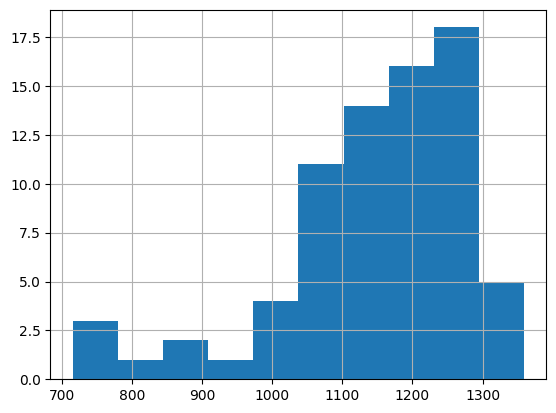

In [74]:
all_df.region.value_counts().hist()

In [81]:
region_counts = all_df.region.value_counts().sort_values()

N = 5
largest_counts = region_counts.tail(N)
smallest_counts = region_counts.head(N)

display(smallest_counts)
display(largest_counts)

region
97    716
94    717
95    753
96    805
98    889
Name: count, dtype: int64

region
2162    1299
56      1300
2163    1303
41      1329
2145    1359
Name: count, dtype: int64

In [39]:
all_df["delta_days"] = all_df.groupby("region")["acquired"].diff().dt.total_seconds() / (24 * 3600)

# 3. Compute quantiles per region
summary = (
    all_df.groupby("region")["delta_days"]
    .quantile([0.5, 0.95, 0.99])  # 0.5 = p50, 0.95 = p95
    .unstack(level=-1)
    .rename(columns={0.5: "p50_days", 0.95: "p95_days", 0.99: "p99_days"})
)

summary.round(3).to_csv("/Users/kyledorman/data/estuary/display/ca_site_temporal.csv")

summary.round(1)

,p50_days,p95_days,p99_days
region,,,
11,2.0,7.0,14.0
12,1.9,7.0,13.0
14,1.9,8.0,13.2
15,2.0,8.0,13.0
16,1.9,7.0,13.0
...,...,...,...
2145,1.0,7.0,12.4
2147,2.0,10.0,18.0
2161,1.1,8.0,15.4


In [41]:
N = 5
# Top N worst (largest) p95
worst_p95 = summary.sort_values("p95_days", ascending=False).head(N)

# Top N worst (largest) p99
worst_p99 = summary.sort_values("p99_days", ascending=False).head(N)

display(worst_p95.round(1))
display(worst_p99.round(1))

,p50_days,p95_days,p99_days
region,,,
97,2.0,13.3,27.9
94,2.0,13.0,26.0
95,2.0,12.0,26.0
96,2.0,11.0,22.9
93,2.0,11.0,19.0


,p50_days,p95_days,p99_days
region,,,
97,2.0,13.3,27.9
94,2.0,13.0,26.0
95,2.0,12.0,26.0
98,2.0,10.0,23.1
96,2.0,11.0,22.9


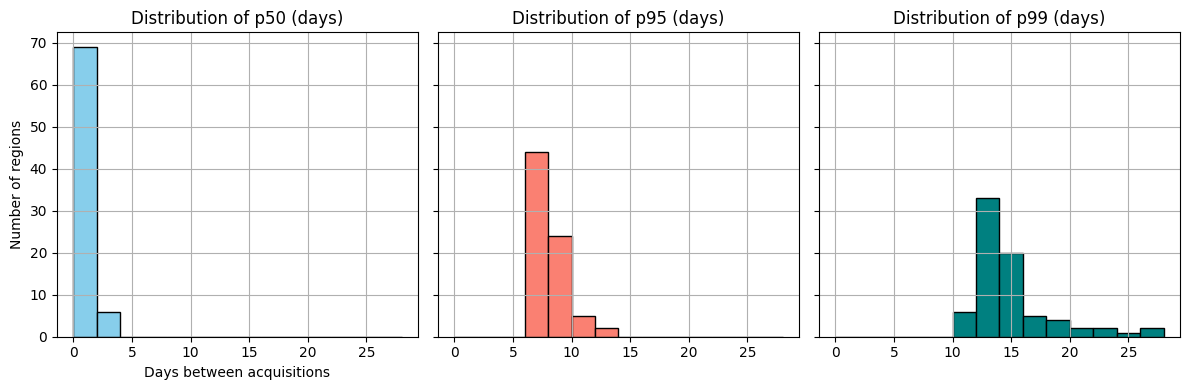

In [69]:
import matplotlib.pyplot as plt
import numpy as np

mv = np.ceil(summary["p99_days"].max())
bins = np.linspace(0, mv, int(mv) // 2 + 1)

fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharey=True)

summary["p50_days"].hist(ax=axes[0], bins=bins, color="skyblue", edgecolor="k")
axes[0].set_title("Distribution of p50 (days)")
axes[0].set_ylabel("Number of regions")
axes[0].set_xlabel("Days between acquisitions")

summary["p95_days"].hist(ax=axes[1], bins=bins, color="salmon", edgecolor="k")
axes[1].set_title("Distribution of p95 (days)")

summary["p99_days"].hist(ax=axes[2], bins=bins, color="teal", edgecolor="k")
axes[2].set_title("Distribution of p99 (days)")

plt.tight_layout()
plt.savefig("/Users/kyledorman/data/estuary/display/ca_time_between.png")
plt.show()

In [60]:
gdf.head()

,Latitude,Longitude,Region,Nation,Site name,Studied (1) / Not Studied (0),station_nm,site_no,site_latitude,site_longitude,geometry
Site code,,,,,,,,,,,
11,32.933,-117.260,North America,USA,Los Penasquitos Lagoon,1,None,None,None,None,POINT (-117.26 32.933)
12,33.166,-117.358,North America,USA,Buena Vista Lagoon,0,None,None,None,None,POINT (-117.358 33.166)
14,33.203,-117.391,North America,USA,San Luis Rey River,0,None,None,None,None,POINT (-117.391 33.203)
15,33.231,-117.416,North America,USA,Santa Margarita River,1,SANTA MARGARITA RIVER ESTUARY NR OCEANSIDE CA,11046050,33.2294795,-117.4103174,POINT (-117.416 33.231)
16,33.291,-117.465,North America,USA,Las Fores Creek,0,LAS FLORES C LAGOON A MOUTH NR OCEANSIDE CA,11046102,33.29055556,-117.465,POINT (-117.465 33.291)


In [68]:
import folium
import geopandas as gpd
from branca.colormap import linear

gdf["region"] = gdf.index

# Suppose:
# - summary has index "region" and columns including p99_days
# - gdf is a GeoDataFrame with a "region" column and Point geometries

# 2. Join stats to gdf
gdf_stats = gdf.merge(summary[["p95_days"]], on="region", how="inner")

# 3. Create folium map, centered roughly on your data
m = folium.Map(
    location=[gdf_stats.geometry.y.mean(), gdf_stats.geometry.x.mean()],
    zoom_start=6,
    tiles="cartodbpositron",
    width=600,
    height=600,
)

# 4. Set up color scale for p99 values
colormap = linear.YlOrRd_09.scale(gdf_stats["p95_days"].min(), gdf_stats["p95_days"].max())
colormap.caption = "p95 days between acquisitions"

# 5. Add points with colors
for _, row in gdf_stats.iterrows():
    if pd.notnull(row["p95_days"]):
        color = colormap(row["p95_days"])
        folium.CircleMarker(
            location=[row.geometry.y, row.geometry.x],
            radius=5,
            fill=True,
            fill_opacity=0.8,
            color=color,
            popup=f"Region: {row['region']}<br>p99: {row['p95_days']:.1f} days",
        ).add_to(m)

# 6. Add colorbar legend
colormap.add_to(m)

m